# Vaccination model - Intervention

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import model
import pickle
import itertools
import networkx as nx
import geopandas as gp
from tqdm import tqdm, tqdm_notebook
%matplotlib inline

### Prepare data and network

In [2]:
prep_data = model.data_and_network_prep()

In [3]:
# Create data for the fit
data_for_fit = model.create_data_for_fit(prep_data)

## Grid Search

#### Load results

In [4]:
with open('L:/Dor/Data/vaccination_model/grid_search_5_res.pickle', 'rb') as pickle_in:
    grid_search_res_1 = pickle.load(pickle_in)
    
with open('L:/Dor/Data/vaccination_model/grid_search_6_res.pickle', 'rb') as pickle_in:
    grid_search_res_2 = pickle.load(pickle_in)
    
grid_search_res = grid_search_res_1 + grid_search_res_2

#### Get best parametrs according to each likelihhood function

In [5]:
# Max likelihood 
liklihood = max(grid_search_res, key=lambda x: x['log_likelihood'])

# Max likelihood age
liklihood_age = max(grid_search_res, key=lambda x: x['log_likelihood_age'])

# Max likelihood subdist
liklihood_subdist = max(grid_search_res, key=lambda x: x['log_likelihood_subdist'])

# Min MSE age
mse_age = min(grid_search_res, key=lambda x: x['mse_by_age'])

# Min MSE subdsit
mse_subdist = min(grid_search_res, key=lambda x: x['mse_by_subdist'])

print(f"Max likelihood: {int(liklihood['log_likelihood']):,d}")
print(liklihood_age)
print('\n')

print(f"Max likelihood by age: {int(liklihood_age['log_likelihood_age']):,d}")
print(liklihood_age)
print('\n')

print(f"Max likelihood by subdist: {int(liklihood_subdist['log_likelihood_subdist']):,d}")
print(liklihood_subdist)
print('\n')

print(f"Min MSE by age: {int(mse_age['mse_by_age']):,d}")
print(mse_age)
print('\n')

print(f"Min MSE by subdist: {int(mse_subdist['mse_by_subdist']):,d}")
print(mse_subdist)
print('\n')

Max likelihood: -9,563
{'parameters': {'beta_2': 0.018256229669662005, 'delta': 0.3023799800470099, 'gamma': 0.1722076679492849, 'I_0_size': 0.0004}, 'log_likelihood': -14651.78454284373, 'log_likelihood_age': 204850.32093978545, 'log_likelihood_subdist': 32733.471959804305, 'mse_by_age': 17572.497704821068, 'mse_by_subdist': 3795.177506448156}


Max likelihood by age: 204,850
{'parameters': {'beta_2': 0.018256229669662005, 'delta': 0.3023799800470099, 'gamma': 0.1722076679492849, 'I_0_size': 0.0004}, 'log_likelihood': -14651.78454284373, 'log_likelihood_age': 204850.32093978545, 'log_likelihood_subdist': 32733.471959804305, 'mse_by_age': 17572.497704821068, 'mse_by_subdist': 3795.177506448156}


Max likelihood by subdist: 36,129
{'parameters': {'beta_2': 0.016863165243777217, 'delta': 0.278572631507307, 'gamma': 0.19172052098205442, 'I_0_size': 0.001}, 'log_likelihood': -9563.146711506553, 'log_likelihood_age': 197267.18472100564, 'log_likelihood_subdist': 36129.114564781725, 'mse_by_

## Intervention

In [6]:
# run_model = model.run_model

# def calc_model_vaccination_coverage_intervention(intervention_nodes, parameters, prep_data, num_of_simulations):
#     # Initialize a list for the infection rates
#     vacc_coverage_list = []
    
#     # Run the model num_of_simulations times
#     for i in range(num_of_simulations):
#         # Run model
#         model_results = run_model(parameters, prep_data, initial_I=intervention_nodes)

#         # Calculate infection rate and add to the list
#         vacc_coverage = len(model_results['R'][-1].union(model_results['I'][-1])) / model_results['N']
#         vacc_coverage_list.append(vacc_coverage)
        
#     # Get median realization
#     med = np.argsort(np.array(vacc_coverage_list))[len(vacc_coverage_list) // 2]

#     return vacc_coverage_list[med]

In [7]:
run_model = model.run_model

def calc_model_vaccination_coverage_intervention(intervention_nodes, parameters, prep_data, data_for_fit, num_of_simulations):
    # Initialize a list for the infection rates
    vacc_coverage_list = []
    
    # Run the model num_of_simulations times
    for i in range(num_of_simulations):
        # Run model
        model_results = run_model(parameters, prep_data, initial_I=intervention_nodes)

        # Calculate infection rate and add to the list
        vacc_coverage = model.get_vaccination_coverage_by_age(model_results, data_for_fit, prep_data).model
        vacc_coverage_list.append(vacc_coverage)
        
    # Get median realization by total vaccination coverage
    total_vacc_coverage_list = list(map(lambda x: x['total'], vacc_coverage_list))
    med = np.argsort(np.array(total_vacc_coverage_list))[len(vacc_coverage_list) // 2]

    return vacc_coverage_list[med]

In [8]:
# Number of simulations
m = 20

intervention_percent = 0.1
intervention_size = int(round(prep_data['network'].number_of_nodes()*intervention_percent))

# parametes = liklihood['parameters']
# parameters = liklihood_age['parameters']
parameters = liklihood_subdist['parameters']
parameters['beta'] = parameters['beta_2']

### No intervention

In [9]:
vacc_coverage_no_inter = calc_model_vaccination_coverage_intervention(set(), parameters, prep_data,
                                                                      data_for_fit, num_of_simulations=m)

In [10]:
print(f'Vaccination coverage: {vacc_coverage_no_inter["total"]*100:.2f}%')

Vaccination coverage: 20.00%


### Random intervention

In [11]:
# Choose ranmdom nodes to infect
initial_I_random = set(np.random.choice(list(prep_data['network'].nodes), replace=False, size=intervention_size))
vacc_coverage_random = calc_model_vaccination_coverage_intervention(initial_I_random, parameters, prep_data, data_for_fit,
                                                                    num_of_simulations=m)

In [12]:
print('Random intervention:')
print(f'Vaccination coverage: {vacc_coverage_random["total"]*100:.2f}%')
print(f'Vaccination coverage increase: {(vacc_coverage_random["total"]-vacc_coverage_no_inter["total"])*100:.2f}%')
print(f'Vaccination coverage effective increase: {(vacc_coverage_random["total"]-vacc_coverage_no_inter["total"]-intervention_percent)*100:.2f}%')

Random intervention:
Vaccination coverage: 34.47%
Vaccination coverage increase: 14.47%
Vaccination coverage effective increase: 4.47%


### Centrality-based intervention

### Area-based centrality

#### Areas PageRank

In [39]:
# Load nodes by area and age
with open(model.nodes_by_area_age_dict_path, 'rb') as pickle_in:
    nodes_by_area_age = pickle.load(pickle_in)

In [71]:
# Load page ranks
# with open(model.pagerank_by_area_age_path, 'rb') as pickle_in:
# with open('../../Data/vaccination_data/pagerank_by_area_age_thresh.pickle', 'rb') as pickle_in:
with open('../../Data/vaccination_data/pagerank_by_area_age_net.pickle', 'rb') as pickle_in:
    pageranks = pickle.load(pickle_in)
    
# Sort areas and age groups by page rank (descending)
areas_age_by_rank_with_rank = sorted(list(pageranks.items()), key=lambda x: x[1], reverse=True)
areas_age_by_rank = list(map(lambda x: x[0], areas_age_by_rank_with_rank))

# Load nodes by area and age
with open(model.nodes_by_area_age_dict_path, 'rb') as pickle_in:
    nodes_by_area_age = pickle.load(pickle_in)
    
# Fliter irrelevant areas
areas_age_by_rank = list(filter(lambda x: x in nodes_by_area_age, areas_age_by_rank))
areas_age_by_rank_with_rank = list(filter(lambda x: x[0] in nodes_by_area_age, areas_age_by_rank_with_rank))

    
# Create a list of nodes by PageRank
nodes_by_rank = []
for (area, age) in areas_age_by_rank:
    nodes_by_rank += list(nodes_by_area_age[(area, age)])
    
# Get nodes to vaccinate
initial_I_center_areas_PR = set(nodes_by_rank[:intervention_size])

In [72]:
vacc_coverage_areas_PR = calc_model_vaccination_coverage_intervention(initial_I_center_areas_PR, parameters, prep_data,
                                                                      data_for_fit, num_of_simulations=3)

In [73]:
print('By areas PageRank:')
print(f'Vaccination coverage: {vacc_coverage_areas_PR["total"]*100:.2f}%')
print(f'Vaccination coverage increase: {(vacc_coverage_areas_PR["total"]-vacc_coverage_no_inter["total"])*100:.2f}%')
print(f'Vaccination coverage effective increase: {(vacc_coverage_areas_PR["total"]-vacc_coverage_no_inter["total"]-intervention_percent)*100:.2f}%')

By areas PageRank:
Vaccination coverage: 31.57%
Vaccination coverage increase: 11.57%
Vaccination coverage effective increase: 1.57%


#### By area eigenvector centrality

In [17]:
# Load area EV centrality
with open('../../Data/vaccination_data/eigenvector_by_area_age.pickle', 'rb') as pickle_in:
    EV_centrality = pickle.load(pickle_in)
    
# Sort areas and age groups by page rank (descending)
areas_age_by_EV_with_rank = sorted(list(EV_centrality.items()), key=lambda x: x[1], reverse=True)
areas_age_by_EV = list(map(lambda x: x[0], areas_age_by_rank_with_rank))

# Load nodes by area and age
with open(model.nodes_by_area_age_dict_path, 'rb') as pickle_in:
    nodes_by_area_age = pickle.load(pickle_in)
    
# Fliter irrelevant areas
areas_age_by_EV = list(filter(lambda x: x in nodes_by_area_age, areas_age_by_EV))
areas_age_by_EV_with_rank = list(filter(lambda x: x[0] in nodes_by_area_age, areas_age_by_EV_with_rank))

    
# Create a list of nodes by PageRank
nodes_by_EV = []
for (area, age) in areas_age_by_rank:
    nodes_by_EV += list(nodes_by_area_age[(area, age)])
    
# Get nodes to vaccinate
initial_I_center_areas_EV = set(nodes_by_rank[:intervention_size])

In [18]:
vacc_coverage_areas_EV = calc_model_vaccination_coverage_intervention(initial_I_center_areas_EV, parameters, prep_data,
                                                                      data_for_fit, num_of_simulations=m)

In [19]:
print('By areas EV:')
print(f'Vaccination coverage: {vacc_coverage_areas_PR["total"]*100:.2f}%')
print(f'Vaccination coverage increase: {(vacc_coverage_areas_PR["total"]-vacc_coverage_no_inter["total"])*100:.2f}%')
print(f'Vaccination coverage effective increase: {(vacc_coverage_areas_PR["total"]-vacc_coverage_no_inter["total"]-intervention_percent)*100:.2f}%')

By areas EV:
Vaccination coverage: 31.08%
Vaccination coverage increase: 11.08%
Vaccination coverage effective increase: 1.08%


#### Subgraphs areas PageRank (by subdist and age)

In [20]:
# Load page ranks - for each subdist separately
with open('../../Data/vaccination_data/sub_graphs_areas_pageranks.pickle', 'rb') as pickle_in:
    sub_graphs_areas_pageranks = pickle.load(pickle_in)

    # Load nodes by area and age
with open(model.nodes_by_area_age_dict_path, 'rb') as pickle_in:
    nodes_by_area_age = pickle.load(pickle_in)
    
# Caculate population proportion by subdist and age
population_by_subdist = prep_data['population_by_clinic_age'].reset_index().groupby(['subdist', 'age']).sum()[['network_population']]
population_by_subdist['pop_prop'] = population_by_subdist.network_population / population_by_subdist.network_population.sum()

# Initialize a set for the nodes to vaccinate
subgraph_area_PR_nodes = set()

# Go over subdist and age and choose top nodes by subgraph PageRank
for subdist, age in prep_data['relevant_subdists_age']:
    # Sort nodes groups by page rank (descending)
    areas_by_subgraph_area_PR_with_rank = sorted(list(sub_graphs_areas_pageranks[(subdist, age)].items()), key=lambda x: x[1], reverse=True)
    areas_by_areas_subgraph_PR = list(map(lambda x: x[0], areas_by_subgraph_area_PR_with_rank))
    # Create a list of nodes by PageRank for current subdist and age
    nodes_by_rank = []
    for (area, age) in areas_by_areas_subgraph_PR:
        nodes_by_rank += list(nodes_by_area_age[(area, age)])
    # The number of nodes to vaccionate is according to the population proportion
    num_of_nodes = int(population_by_subdist.loc[(subdist, age)].pop_prop * intervention_size)
    # Get nodes to vaccinate in current subdist and age
    nodes_to_vacc_subdist = set(nodes_by_rank[:num_of_nodes])
    # Add to the set of nodes to vaccinate
    subgraph_area_PR_nodes = subgraph_area_PR_nodes.union(nodes_to_vacc_subdist)

In [21]:
vacc_coverage_subgraph_area_PR = calc_model_vaccination_coverage_intervention(subgraph_area_PR_nodes, parameters, prep_data,
                                                                      data_for_fit, num_of_simulations=m)

In [22]:
print('By areas subgraph PageRank:')
print(f'Vaccination coverage: {vacc_coverage_subgraph_area_PR["total"]*100:.2f}%')
print(f'Vaccination coverage increase: {(vacc_coverage_subgraph_area_PR["total"]-vacc_coverage_no_inter["total"])*100:.2f}%')
print(f'Vaccination coverage effective increase: {(vacc_coverage_subgraph_area_PR["total"]-vacc_coverage_no_inter["total"]-intervention_percent)*100:.2f}%')

By areas subgraph PageRank:
Vaccination coverage: 32.82%
Vaccination coverage increase: 12.81%
Vaccination coverage effective increase: 2.81%


### Node-based centrality

#### Nodes PageRank

In [43]:
# Load page ranks
with open('../../Data/vaccination_data/pagerank_by_node.pickle', 'rb') as pickle_in:
    pageranks_by_node = pickle.load(pickle_in)
    
# Sort areas and age groups by page rank (descending)
nodes_by_rank_with_rank = sorted(list(pageranks_by_node.items()), key=lambda x: x[1], reverse=True)
nodes_by_nodes_pagerank = list(map(lambda x: x[0], nodes_by_rank_with_rank))

# Get nodes to vaccinate
initial_I_center_nodes_PR = set(nodes_by_nodes_pagerank[:intervention_size])

In [69]:
vacc_coverage_nodes_PR = calc_model_vaccination_coverage_intervention(initial_I_center_nodes_PR, parameters, prep_data,
                                                                      data_for_fit, num_of_simulations=m)

In [70]:
print('By nodes PageRank:')
print(f'Vaccination coverage: {vacc_coverage_nodes_PR["total"]*100:.2f}%')
print(f'Vaccination coverage increase: {(vacc_coverage_nodes_PR["total"]-vacc_coverage_no_inter["total"])*100:.2f}%')
print(f'Vaccination coverage effective increase: {(vacc_coverage_nodes_PR["total"]-vacc_coverage_no_inter["total"]-intervention_percent)*100:.2f}%')

By nodes PageRank:
Vaccination coverage: 34.57%
Vaccination coverage increase: 14.57%
Vaccination coverage effective increase: 4.57%


#### Nodes degree

In [26]:
# Sort nodes by degree (descending)
nodes_by_dgree_with_dgree = sorted(list(dict(prep_data['network'].degree).items()), key=lambda x: x[1], reverse=True)
nodes_by_dgree = list(map(lambda x: x[0], nodes_by_dgree_with_dgree))

# Get nodes to vaccinate
initial_I_nodes_degree = set(nodes_by_dgree[:intervention_size])

In [27]:
vacc_coverage_nodes_degree = calc_model_vaccination_coverage_intervention(initial_I_nodes_degree, parameters, prep_data,
                                                                      data_for_fit, num_of_simulations=m)

In [28]:
print('By nodes degree:')
print(f'Vaccination coverage: {vacc_coverage_nodes_degree["total"]*100:.2f}%')
print(f'Vaccination coverage increase: {(vacc_coverage_nodes_degree["total"]-vacc_coverage_no_inter["total"])*100:.2f}%')
print(f'Vaccination coverage effective increase: {(vacc_coverage_nodes_degree["total"]-vacc_coverage_no_inter["total"]-intervention_percent)*100:.2f}%')

By nodes degree:
Vaccination coverage: 34.75%
Vaccination coverage increase: 14.75%
Vaccination coverage effective increase: 4.75%


#### By node eigenvector centrality

In [29]:
# Load page ranks
with open('../../Data/vaccination_data/eigenvector_by_node_dict.pickle', 'rb') as pickle_in:
    EV_by_node = pickle.load(pickle_in)
    
# Sort areas and age groups by EV(descending)
nodes_by_EV_with_rank = sorted(list(EV_by_node.items()), key=lambda x: x[1], reverse=True)
nodes_by_nodes_EV = list(map(lambda x: x[0], nodes_by_EV_with_rank))

# Get nodes to vaccinate
initial_I_center_nodes_EV = set(nodes_by_nodes_EV[:intervention_size])

In [30]:
vacc_coverage_nodes_EV = calc_model_vaccination_coverage_intervention(initial_I_center_nodes_EV, parameters, prep_data,
                                                                      data_for_fit, num_of_simulations=m)

In [31]:
print('By nodes PageRank:')
print(f'Vaccination coverage: {vacc_coverage_nodes_EV["total"]*100:.2f}%')
print(f'Vaccination coverage increase: {(vacc_coverage_nodes_EV["total"]-vacc_coverage_no_inter["total"])*100:.2f}%')
print(f'Vaccination coverage effective increase: {(vacc_coverage_nodes_EV["total"]-vacc_coverage_no_inter["total"]-intervention_percent)*100:.2f}%')

By nodes PageRank:
Vaccination coverage: 32.57%
Vaccination coverage increase: 12.56%
Vaccination coverage effective increase: 2.56%


#### Subgraphs nodes PageRank (by subdist and age)

In [32]:
# Load page ranks - for each subdist separately
with open('../../Data/vaccination_data/sub_graphs_pageranks.pickle', 'rb') as pickle_in:
    sub_graphs_pageranks = pickle.load(pickle_in)

# Caculate population proportion by subdist and age
population_by_subdist = prep_data['population_by_clinic_age'].reset_index().groupby(['subdist', 'age']).sum()[['network_population']]
population_by_subdist['pop_prop'] = population_by_subdist.network_population / population_by_subdist.network_population.sum()

# Initialize a set for the nodes to vaccinate
subgraph_PR_nodes = set()

# Go over subdist and age and choose top nodes by subgraph PageRank
for subdist, age in prep_data['relevant_subdists_age']:
    # Sort nodes groups by page rank (descending)
    nodes_by_subgraph_PR_with_rank = sorted(list(sub_graphs_pageranks[(subdist, age)].items()), key=lambda x: x[1], reverse=True)
    nodes_by_nodes_subgraph_PR = list(map(lambda x: x[0], nodes_by_subgraph_PR_with_rank))
    # The number of nodes to vaccionate is according to the population proportion
    num_of_nodes = int(population_by_subdist.loc[(subdist, age)].pop_prop * intervention_size)
    # Get nodes to vaccinate in current subdist and age
    nodes_to_vacc_subdist = set(nodes_by_nodes_subgraph_PR[:num_of_nodes])
    # Add to the set of nodes to vaccinate
    subgraph_PR_nodes = subgraph_PR_nodes.union(nodes_to_vacc_subdist)

In [33]:
vacc_coverage_nodes_subgraph_PR = calc_model_vaccination_coverage_intervention(subgraph_PR_nodes, parameters, prep_data,
                                                                      data_for_fit, num_of_simulations=m)

In [34]:
print('By nodes PageRank:')
print(f'Vaccination coverage: {vacc_coverage_nodes_subgraph_PR["total"]*100:.2f}%')
print(f'Vaccination coverage increase: {(vacc_coverage_nodes_subgraph_PR["total"]-vacc_coverage_no_inter["total"])*100:.2f}%')
print(f'Vaccination coverage effective increase: {(vacc_coverage_nodes_subgraph_PR["total"]-vacc_coverage_no_inter["total"]-intervention_percent)*100:.2f}%')

By nodes PageRank:
Vaccination coverage: 34.21%
Vaccination coverage increase: 14.21%
Vaccination coverage effective increase: 4.21%


## Intervention summary

In [35]:
intervention_vacc_coverage_list = [vacc_coverage_no_inter, vacc_coverage_random, vacc_coverage_areas_PR,
                                   vacc_coverage_areas_EV, vacc_coverage_subgraph_area_PR, vacc_coverage_nodes_PR,
                                   vacc_coverage_nodes_EV, vacc_coverage_nodes_degree, vacc_coverage_nodes_subgraph_PR]

intervention_vacc_coverage_dict = {'no intervention': vacc_coverage_no_inter, 'random': vacc_coverage_random,
                                   'areas\nPageRank': vacc_coverage_areas_PR, 'areas EV': vacc_coverage_areas_EV,
                                   'areas subgraph\nPageRank': vacc_coverage_subgraph_area_PR,
                                   'nodes\nPageRank': vacc_coverage_nodes_PR, 'nodes EV': vacc_coverage_nodes_EV,
                                   'nodes\ndegree': vacc_coverage_nodes_degree, 'nodes subgraph\nPageRank': vacc_coverage_nodes_subgraph_PR}


names = ['no intervention', 'random', 'areas\nPageRank', 'areas EV','areas subgraph\nPageRank',
         'nodes\nPageRank', 'nodes EV', 'nodes\ndegree', 'nodes subgraph\nPageRank']

# intervention_vacc_coverage = pd.DataFrame(index=pd.Index(['children', 'adults', 'total'], name='age'))
# for i, res in enumerate(intervention_vacc_coverage_list):
#     intervention_vacc_coverage[names[i]] = intervention_vacc_coverage_list[i]
    
intervention_vacc_coverage = pd.DataFrame(index=pd.Index(['children', 'adults', 'total'], name='age'))
for name, coverage in intervention_vacc_coverage_dict.items():
    intervention_vacc_coverage[name] = coverage

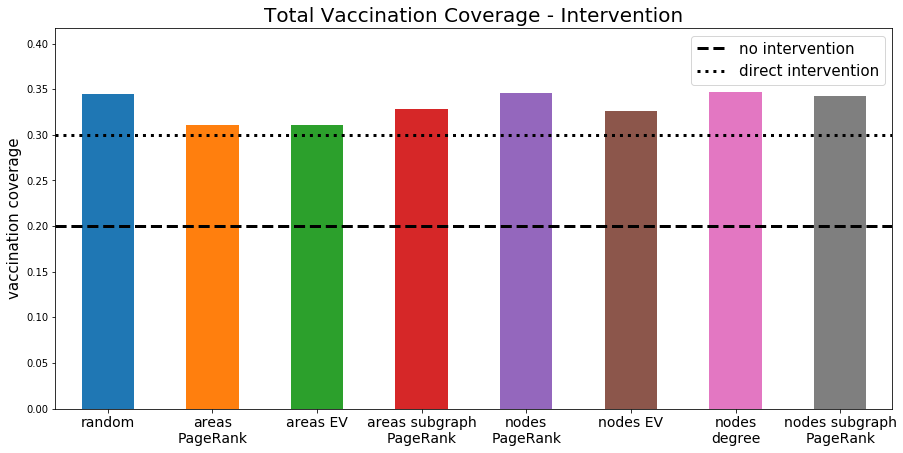

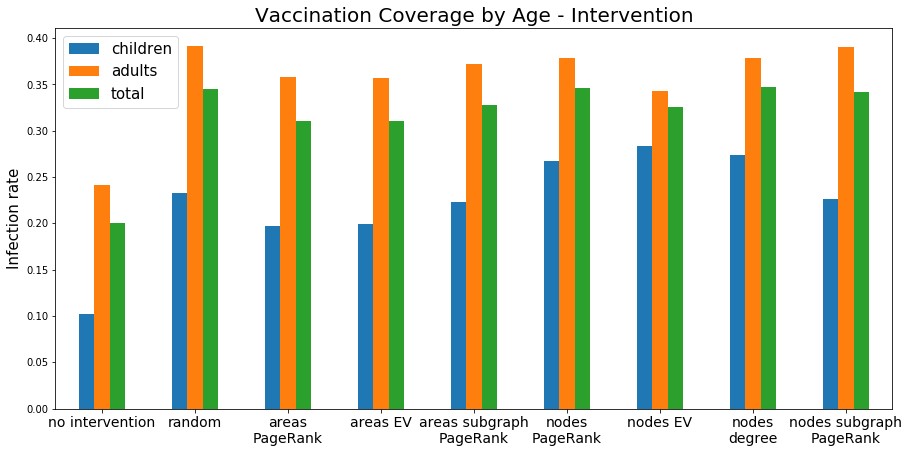

,no intervention,random,areas PageRank,areas EV,areas subgraph PageRank,nodes PageRank,nodes EV,nodes degree,nodes subgraph PageRank
age,,,,,,,,,
children,0.101632,0.233124,0.196652,0.199614,0.222620,0.267564,0.283889,0.274108,0.226064
adults,0.241057,0.391216,0.358432,0.356535,0.372181,0.378373,0.343088,0.378171,0.390541
total,0.200016,0.344681,0.310811,0.310344,0.328156,0.345755,0.325662,0.347540,0.342126


In [36]:
# Get only total
intervention_total_vacc_coverage = intervention_vacc_coverage.iloc[2,1:]

# Plot
intervention_total_vacc_coverage.T.plot.bar(figsize=(15, 7))
plt.title('Total Vaccination Coverage - Intervention', size=20)
plt.xlabel('', size=15)
plt.ylabel('vaccination coverage', size=15)
plt.xticks(np.arange(8), intervention_total_vacc_coverage.T.index, rotation='horizontal', size=14)
# plt.legend(fontsize=15)

# Total infection rate no intervention
no_inter_line = plt.hlines(intervention_vacc_coverage.loc['total', 'no intervention'], -0.5, 8,
           linestyle ='--', linewidth=3, color='black', label='no intervention')

direct_increase = plt.hlines(intervention_vacc_coverage.loc['total', 'no intervention'] + intervention_percent, -0.5, 8,
           linestyle ='dotted', linewidth=3, color='black', label='direct intervention')

plt.ylim([0, intervention_total_vacc_coverage.max()*1.2])
plt.legend([no_inter_line, direct_increase], ['no intervention', 'direct intervention'], fontsize=15)


plt.show()


# Plot infection rates by age
intervention_vacc_coverage.T.plot.bar(figsize=(15, 7))
plt.title('Vaccination Coverage by Age - Intervention', size=20)
plt.xlabel('', size=15)
plt.ylabel('Infection rate', size=15)
plt.xticks(np.arange(9), intervention_vacc_coverage.T.index, rotation='horizontal', size=14)
plt.legend(fontsize=15)
plt.show()

intervention_vacc_coverage

#### Marginal addition

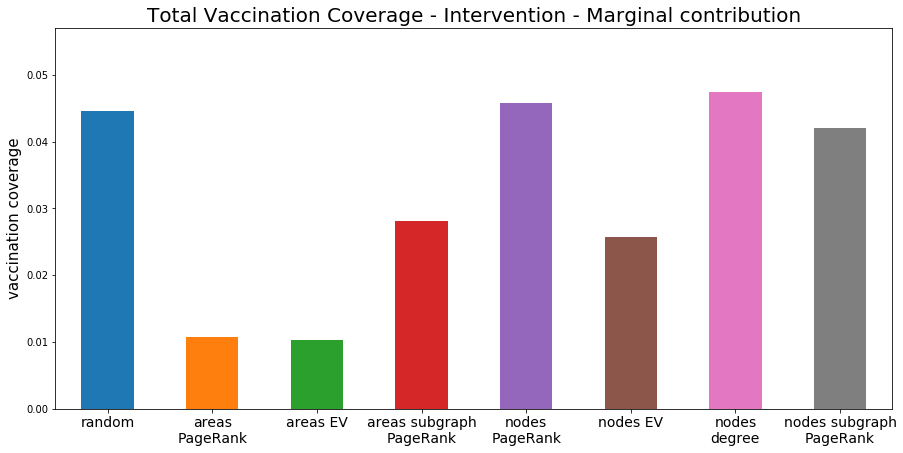

In [37]:
# Get only total
intervention_total_vacc_coverage_additional = intervention_vacc_coverage.iloc[2,1:]
intervention_total_vacc_coverage_additional -= intervention_vacc_coverage.loc['total', 'no intervention'] + intervention_percent

# Plot
intervention_total_vacc_coverage_additional.T.plot.bar(figsize=(15, 7))
plt.title('Total Vaccination Coverage - Intervention - Marginal contribution', size=20)
plt.xlabel('', size=15)
plt.ylabel('vaccination coverage', size=15)
plt.xticks(np.arange(8), intervention_total_vacc_coverage_additional.T.index, rotation='horizontal', size=14)
# plt.legend(fontsize=15)

plt.ylim([0, intervention_total_vacc_coverage_additional.max()*1.2])
# plt.legend([no_inter_line, direct_increase], ['no intervention', 'direct intervention'], fontsize=15)


plt.show()


In [38]:
intervention_total_vacc_coverage_additional

random                      0.044665
areas\nPageRank             0.010795
areas EV                    0.010328
areas subgraph\nPageRank    0.028140
nodes\nPageRank             0.045739
nodes EV                    0.025646
nodes\ndegree               0.047523
nodes subgraph\nPageRank    0.042110
Name: total, dtype: float64

### Our approach

In [40]:
def get_nodes_to_vaccinate(node_ranks, iteration_percent, intervention_percent, parameters, prep_data):
    # Create a deep copy
    node_ranks = [[x[0], x[1].copy()] for x in node_ranks]
    
    # Calculate intervention size
    intervention_size = int(round(prep_data['network'].number_of_nodes()*intervention_percent))
    
    # Initialize a list for the chosen nodes for the intervention
    vaccinated_nodes = []

    # Number of infected contacts
    infected_contacts = dict.fromkeys(prep_data['network'].nodes, 0)

    # n iterations
    # for i in tqdm_notebook(range(21)):
    while len(vaccinated_nodes) < intervention_size:
        # Calculte top number to choose from (top intervention percent out of ramaining nodes)
        top_number = int(len(node_ranks)*intervention_percent)
        # Calculate number to choose
        chosen_number = int(top_number*iteration_percent)

        # Choose q percent out of the top intervention_percent randomly
        chosen_nodes_idx = np.random.choice(range(top_number), size=chosen_number, replace=False)
        chosen_nodes = list(np.array(node_ranks)[chosen_nodes_idx])

        # Add to the vaccinated nodes list
        vaccinated_nodes.extend(list(map(lambda x: x[0], chosen_nodes)))

        # Remove from nodes ranks list
        for node in chosen_nodes:
            node_ranks.remove(list(node))

        # Update number of infected contacts
        for node, _ in chosen_nodes:
            for contact in prep_data['network'][node]:
                infected_contacts[contact] += 1

        # Update weights
        for node, value_dict in node_ranks:
            value_dict['weight'] = 1 - (1 - parameters['beta_2'])**(infected_contacts[node]) if infected_contacts[node]>0 else 1

        # Resort rank list by PR*weight
        node_ranks = sorted(node_ranks, key=lambda x: x[1]['rank']*x[1]['weight'], reverse=True)

    vaccinated_nodes = vaccinated_nodes[:intervention_size]

    return set(vaccinated_nodes)

#### By area PageRank

In [44]:
# Load area page ranks
with open(model.pagerank_by_area_age_path, 'rb') as pickle_in:
    pageranks = pickle.load(pickle_in)

# Create a list with all nodes, their PR (according to area and age) and weight (initialized to 1)
nodes_ranks = []
for (area, age), nodes in nodes_by_area_age.items():
    for node in nodes:
        nodes_ranks.append([node, {'rank': pageranks[(area, age)], 'weight': 1}])

# Sort list by PR*weight descending
nodes_by_area_pageranks = sorted(nodes_ranks, key=lambda x: x[1]['rank']*x[1]['weight'], reverse=True)

In [45]:
# Iteration percents to check
iteration_percents = [0.001, 0.005 ,0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]

# Get the initial nodes to vaccinate for each iteration percent
initial_I_area_pagerank_list =\
                [get_nodes_to_vaccinate(nodes_by_area_pageranks, percent, intervention_percent, parameters, prep_data) 
                 for percent in iteration_percents]

# Get infection rate for each iteration percent
area_pagerank_infection_rates = [model.calc_model_infection_rate_intervention(initial_I, parameters, prep_data, 5)
                                 for initial_I in initial_I_area_pagerank_list]

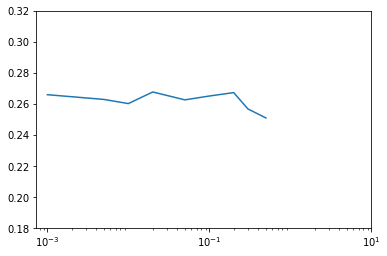

In [91]:
plt.semilogx(iteration_percents, area_pagerank_infection_rates)
plt.ylim([0.18, 0.32])
plt.xticks(np.logspace(-3, 1, 3))
plt.show()

In [64]:
area_pagerank_infection_rates

[0.2658299710062651,
 0.26277853247095556,
 0.26010218770908944,
 0.26757365016929907,
 0.26250481539303744,
 0.26497840676385315,
 0.2671782810567507,
 0.256645242391679,
 0.2508566330771882]

#### By node PageRank

In [46]:
# Load page ranks
with open('../../Data/vaccination_data/pagerank_by_node.pickle', 'rb') as pickle_in:
    pageranks_by_node = pickle.load(pickle_in)
    
# Create a list with all nodes, their PR (according to area and age) and weight (initialized to 1)
nodes_ranks = []
for (area, age), nodes in nodes_by_area_age.items():
    for node in nodes:
        nodes_ranks.append([node, {'rank': pageranks_by_node[node], 'weight': 1}])

# Sort list by PR*weight descending
nodes_by_pageranks = sorted(nodes_ranks, key=lambda x: x[1]['rank']*x[1]['weight'], reverse=True)

In [47]:
# Iteration percents to check
iteration_percents = [0.001, 0.005 ,0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]

# Get the initial nodes to vaccinate for each iteration percent
initial_I_node_pagerank_list =\
                [get_nodes_to_vaccinate(nodes_by_pageranks, percent, intervention_percent, parameters, prep_data) 
                 for percent in iteration_percents]

# Get infection rate for each iteration percent
node_pagerank_infection_rates = [model.calc_model_infection_rate_intervention(initial_I, parameters, prep_data, 5)
                                for initial_I in initial_I_node_pagerank_list]

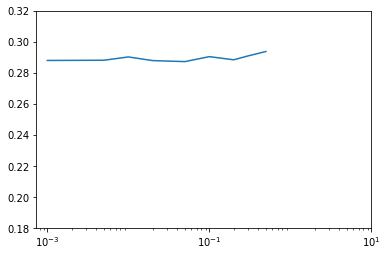

In [90]:
plt.semilogx(iteration_percents, node_pagerank_infection_rates)
plt.ylim([0.18, 0.32])
plt.xticks(np.logspace(-3, 1, 3))
plt.show()

In [92]:
node_pagerank_infection_rates

[0.28786926461345064,
 0.288011191987186,
 0.2901401025932159,
 0.28777802558747795,
 0.28713935240566896,
 0.2903327183147138,
 0.2882950467346566,
 0.2907787757750248,
 0.2936375985888364]

#### By area eigenvector centrality

In [49]:
# Load area EV centrality
with open('../../Data/vaccination_data/eigenvector_by_area_age.pickle', 'rb') as pickle_in:
    EV_centrality = pickle.load(pickle_in)

# Create a list with all nodes, their EV centrality (according to area and age) and weight (initialized to 1)
nodes_EV = []
for (area, age), nodes in nodes_by_area_age.items():
    for node in nodes:
        nodes_EV.append([node, {'rank': EV_centrality[(area, age)], 'weight': 1}])

# Sort list by EV*weight descending
nodes_by_area_EV = sorted(nodes_EV, key=lambda x: x[1]['rank']*x[1]['weight'], reverse=True)

initial_I_area_EV = get_nodes_to_vaccinate(nodes_by_area_EV, 0.2, intervention_percent, parameters, prep_data)

NameError: name 'get_nodes_to_vaccinate' is not defined

In [122]:
mod_res_area_EV = model.run_model(parameters, prep_data, initial_I=initial_I_area_EV)

In [123]:
total_vaccinated_nodes = mod_res_area_EV['R'][-1].union(mod_res_area_EV['I'][-1])
len(total_vaccinated_nodes) / mod_res_area_EV['N']

0.2650189574420632

#### By node eigenvector centrality

In [103]:
# Load page ranks
with open('../../Data/vaccination_data/eigenvector_by_node_dict.pickle', 'rb') as pickle_in:
    EV_by_node = pickle.load(pickle_in)
    
# Create a list with all nodes, their PR (according to area and age) and weight (initialized to 1)
nodes_ranks = []
for (area, age), nodes in nodes_by_area_age.items():
    for node in nodes:
        nodes_ranks.append([node, {'rank': EV_by_node[node], 'weight': 1}])

# Sort list by EV*weight descending
nodes_by_EV = sorted(nodes_ranks, key=lambda x: x[1]['rank']*x[1]['weight'], reverse=True)

In [104]:
initial_I_node_EV = get_nodes_to_vaccinate(nodes_by_EV, 0.2, intervention_percent, parameters, prep_data)

In [108]:
mod_res_node_EV = model.run_model(parameters, prep_data, initial_I=initial_I_node_EV)

In [109]:
vaccinated_nodes = mod_res_node_EV['R'][-1].union(mod_res_node_EV['I'][-1])
len(vaccinated_nodes) / mod_res_node_EV['N']

0.27723484925285374

### For each subdist spearately

Page Rank by areas

In [ ]:
sub_graphs_areas_pageranks_merged

In [127]:
with open('../../Data/vaccination_data/sub_graphs_areas_pageranks.pickle', 'rb') as pickle_in:
    sub_graphs_areas_pageranks = pickle.load(pickle_in)
    
sub_graphs_areas_pageranks_merged = {}
for d in sub_graphs_areas_pageranks.values():
    sub_graphs_areas_pageranks_merged.update(d)
        

# Create a list with all nodes, their EV centrality (according to area and age) and weight (initialized to 1)
nodes_subgraphs_pagerank = []
for (area, age), nodes in nodes_by_area_age.items():
    for node in nodes:
        nodes_subgraphs_pagerank.append([node, {'rank': sub_graphs_areas_pageranks_merged[(area, age)], 'weight': 1}])

# Sort list by EV*weight descending
nodes_by_area_subgraphs_pagerank = sorted(nodes_subgraphs_pagerank, key=lambda x: x[1]['rank']*x[1]['weight'], reverse=True)

In [128]:
initial_I_area_subgraphs_pagerank = get_nodes_to_vaccinate(nodes_by_area_subgraphs_pagerank, 0.2, intervention_percent, parameters, prep_data)

In [129]:
mod_res_area_subgraphs_pagerank = model.run_model(parameters, prep_data, initial_I=initial_I_area_subgraphs_pagerank)

In [131]:
total_vaccinated_nodes = mod_res_area_subgraphs_pagerank['R'][-1].union(mod_res_area_subgraphs_pagerank['I'][-1])
len(total_vaccinated_nodes) / mod_res_area_subgraphs_pagerank['N']

0.26813122199468786

Page rank by nodes

In [60]:
from itertools import product

def plot_vacc_coverage(model_results, prep_data, homogenous=False):
    if not homogenous:
        # Get model coverage by clinic and age
        model_coverage = get_vacc_coverage_by_clinic(model_results, prep_data)
        model_coverage = pd.DataFrame(pd.Series(model_coverage), columns=['model_coverage'])
        model_coverage['clinic_code'] = model_coverage.index.map(lambda x: x[0])
        model_coverage['age'] = model_coverage.index.map(lambda x: x[1])
        model_coverage.set_index(['clinic_code', 'age'], inplace=True)

        # Get vaccination coverage_data and merge with model data
        data_coverage = pd.read_pickle(vaccination_coverage_with_age_path)
        data_coverage = data_coverage.merge(model_coverage, left_index=True, right_index=True)

        # Group by subdist and calculate mean
        vacc_prop_gb_subdist = data_coverage.reset_index().groupby(['subdist', 'age']).mean()[
            ['data_coverage', 'model_coverage']]

    # If homogenous model
    else:
        # Get vaccination coverage_data
        data_coverage = pd.read_pickle(model.vaccination_coverage_with_age_path)

        # Group by subdist and calculate mean
        vacc_prop_gb_subdist = data_coverage.reset_index().groupby(['subdist', 'age']).mean()[['data_coverage']]

        # Only relevant subdists
        vacc_prop_gb_subdist = vacc_prop_gb_subdist.loc[product(prep_data['relevant_subdists'], [0, 1])]

        # model coverage - same coverage for all subdist (only by age)
        vacc_prop_gb_subdist['model_coverage'] =\
            np.tile(((model_results['R'][-1] + model_results['I'][-1]) / model_results['N']),7)

    # Plot
    vacc_prop_gb_subdist.plot.bar(figsize=(15, 7))
    plt.title('Vaccination Coverage by Subdistrict', size=20)
    plt.xlabel('\nSubdistrict', size=15)
    plt.ylabel('Vaccination coverage', size=15)
    plt.xticks(np.arange(14), vacc_prop_gb_subdist.index, rotation='horizontal', size=14)
    plt.legend(fontsize=15, labels=['data', 'model'], loc=(1.01, 0.87))
    plt.show()

    return vacc_prop_gb_subdist

In [59]:
c = np.array([1,2])
np.tile(c, 2)

array([1, 2, 1, 2])

In [57]:
model_results_homo['R'][-1]

array([3475.311618523877, 27361.623329213802], dtype=object)

In [49]:
model_results_homo['N']

array([29005, 69606])

In [30]:
((model_results_homo['R'][-1] + model_results_homo['I'][-1]) / model_results_homo['N']).repeat(7)

array([0.0001003849965372952, 0.0001003849965372952,
       0.0001003849965372952, 0.0001003849965372952,
       0.0001003849965372952, 0.0001003849965372952,
       0.0001003849965372952, 0.2522522136392305, 0.2522522136392305,
       0.2522522136392305, 0.2522522136392305, 0.2522522136392305,
       0.2522522136392305, 0.2522522136392305], dtype=object)

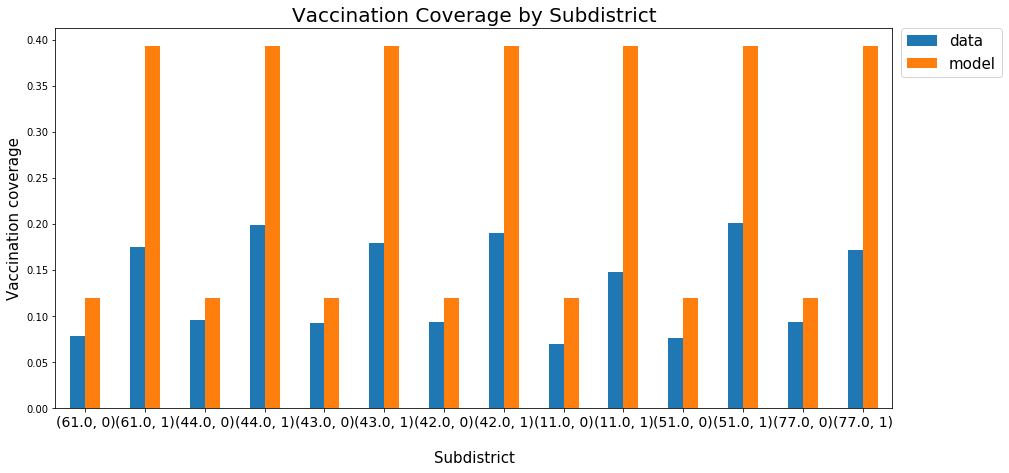

data_coverage model_coverage
subdist age                              
61.0    0         0.078189       0.119822
        1         0.174540       0.393105
44.0    0         0.095571       0.119822
        1         0.199205       0.393105
43.0    0         0.092293       0.119822
        1         0.179640       0.393105
42.0    0         0.093594       0.119822
        1         0.190379       0.393105
11.0    0         0.070085       0.119822
        1         0.148466       0.393105
51.0    0         0.076140       0.119822
        1         0.201007       0.393105
77.0    0         0.094221       0.119822
        1         0.171344       0.393105

In [61]:
plot_vacc_coverage(model_results_homo, prep_data, homogenous=True)

# OLD